# *Dijkstra*: Kürzeste Wege in einem Graphen

Die Suche nach kürzesten Verbindungen in Graphen hat in vielen Bereichen des täglichen Lebens praktische Anwendungen:

- **Navigationssysteme** finden den kürzesten Weg zwischen zwei Orten.
- **Lieferunternehmen** suchen die effizienteste Route für die Zustellung von Waren.
- **Stadtplaner und Verkehrsingenieure** möchten die Verkehrsflüsse optimieren, um Staus zu vermeiden.
- **Routenplanung in Netzwerken** zielt darauf, Datenpakete schnell und effizient zu transportieren.

Bereits 1959 entwickelte der niederländische Mathematiker *E. W. Dijkstra* einen Algorithmus, um in gewichteten ungerichteten Graphen kürzeste Wege zu finden.

Natürlich könnte man alle möglichen Wege zwischen zwei Knoten auflisten, um so den kürzesten Weg zu finden (*brute-force-Ansatz*), doch schon in kleinen Graphen gibt es sehr viele solcher Wege, so dass dieses Verfahren nicht wirklich effizient ist.

Der *Dijkstra-Algorithmus* löst das Problem (erstaunlicherweise) demgegenüber sehr effizient.

In diesem Notebook werden wir diesen Algorithmus an einem Beispiel durchführen.

Dazu benutzten wir
- die Programmiersprache **Python** (in der Version 3.10)
- die **Jupyter-Notebook-Umgebung**
- eine spezielle Python-Bibliothek `networkx`, mit der wir sehr leicht gewichtete Graphen implementieren können.
- eine eigene Python-Bibliothek `attrDirGraph`, die den Umgang mit Graphen methodisch-didaktisch vereinfacht. Sie basiert auf `networkx` (ist davon im Sinne der OOP abgeleitet, stellt also neben neuen Funktionen alle dort implementierten Funktionen zur Verfügung).
- eine weitere eigene Python-Bibliothek `simpleGraph`, die den Umgang mit ungerichteten gewichteten Graphen noch weiter vereinfacht. Diese Klasse erbt (im Sinne der OOP) von der Klasse `attrDirGraph`, stellt also neben neuen Funktionen alle dort implementierten Funktionen zur Verfügung.

Zunächst sollten wir notwendige Begriffe klären:

## Notwendige Bibliotheken importieren

Eine zentrale Rolle spielt die Bibliothek **networkx**. 

Auf der Internetseite findet man dazu:

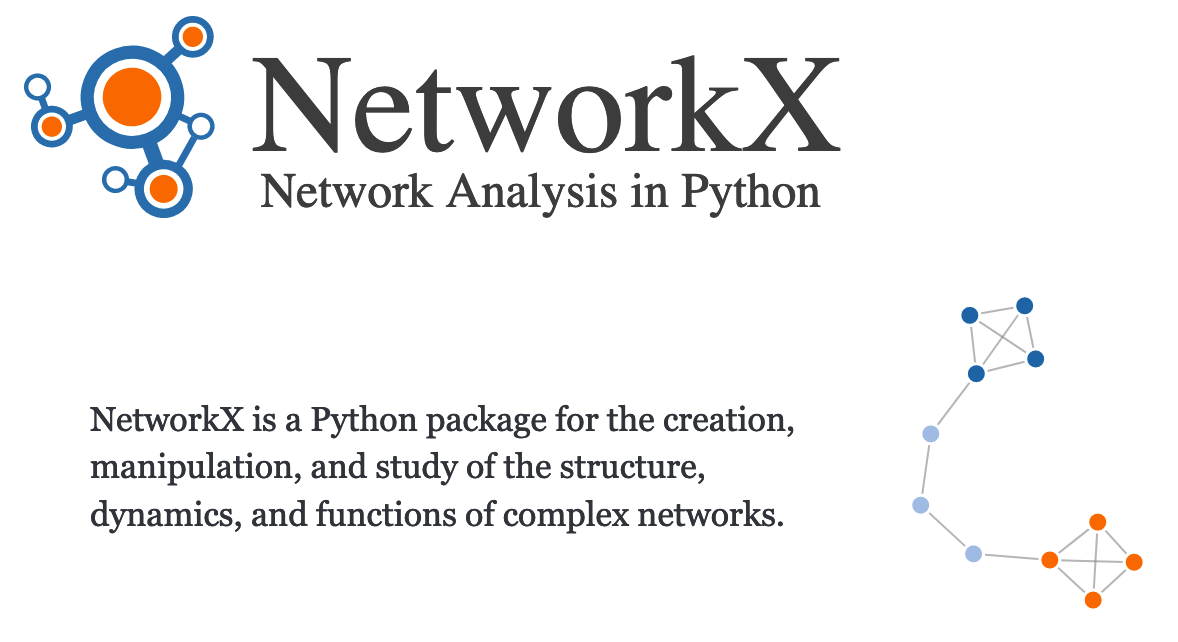

Weitere Bibliotheken, mit deren Hilfe ungerichtete, attributierbare Graphen (und damit auch gewichtete Graphen) möglichst einfach verwaltet werden können, sind unter dem Namen ***attrDirGraph*** und ***simpleGraph***  zugänglich.

Diese drei Bibliotheken müssen zunächst importiert werden:

In [ ]:
import networkx as nx
import GraphBib.attrDirGraph as adg
import GraphBib.simpleGraph as sg

Daneben gibt es für dieses Projekt eine weitere Bibliotheken, mit der man Graphen graphisch darstellen kann:

In [ ]:
# Bibliothek, z.B. um Daten graphisch darzustellen.
import matplotlib.pyplot as plt

## Dokumentation der Bibliotheken `attrDirGraph` und `simpleGraph`

Die Dokumentation der Funktionen der Klasse `simple_graph` können auf Wunsch eingesehen werden. Dazu müssen Sie den Kommentar der folgende Zelle entfernen, dann die Zelle aktivieren:

In [ ]:
# help("attrDirGraph")

In [ ]:
# help("simpleGraph")

## Den gewichteten Graph (Kanten, Knoten, Kantengewichte) aus einer Datei einlesen

Ein *gewichteter Graph* wird beschrieben durch die Angabe der zu dem Graphen gehörenden Kanten. Eine Kante ist dabei ein Objekt, in dem die Namen der beiden Endknoten sowie das Gewicht der Kante (in unserem Beispiel die Länge) enthalten sind.

Da die Knoten, die der Graph enthält, nicht explizit angegeben werden, sondern sich aus den Endknoten der Kanten ergeben, kann man auf diese Weise keine Graphen mit isolierten Knoten erzeugen. Jedoch ist das für unser Beispiel nicht tragisch, da von und zu isolierten Knoten sicherlich kein Weg führt.

Die für einen Graphen notwendigen Daten sollten sich in einer CSV-Datei befinden. Eine solche Datei enthält die Daten (also die Information über eine Kante) zeilenweise, wobei die erste Zeile ein Art Überschrift ist.

Jede Zeile enthält - in der Regel duch Kommata oder Semikolon getrennt - die Werte der jeweiligen Attribute:

- Name des Startknoten
- Name des Zielknoten
- Länge der Kante

Dabei sind in diesem Zusammenhang die Begriffe *Start* und *Ziel* ggf. missverständlich, da die Graphen, die hier benutzt werden, ungerichtet sind; gibt es also eine Kante von A nach B, die in dem Datensatz  angegeben ist, gibt es automatisch auch die Kante von B nach A gleicher Länge, ohne dass sie explizit in den Datensätzen auftaucht.

In [ ]:
# Ein neuer leerer Graph
autobahn = sg.simpleGraph()

# In diesen Graph werden die Informationen aus der Datei eingetragen
autobahn.graphEinlesen("Daten/stdt.txt", sep=",")

### Den Graph visualisieren

Wenn man möchte, kann man den Graphen visualisieren. 

Doch **Vorsicht**: 

- Die Daten in der Datei enthalten keine Angaben über die Lage der Knoten zueinander. Damit ein einigermaßen realistisches Bild der Autobahnverbindungen entstehen kann, wurden in dem folgenden Python-Programm die Längen- und Breitengrade der Städte in Form eines Dictionaries angegeben.

Diese Darstellung ist nur eine nette Spielerei, um die Fähigkeit der Bibliothek zu demonstrieren! In den folgenden Abschnitten, in denen es um kürzeste Verbindungen geht, spielen diese Angaben keine Rolle mehr. 

In [ ]:
# (Grad östl. Länge , Grad nördl. Breite)
pos = {'KI' : (10.12, 54.32), 
       'SN' : (11.40, 53.63), 
       'HH' : ( 9.99, 53.55), 
       'HB' : ( 8.80, 53.07), 
       'BI' : ( 8.53, 52.03), 
       'H'  : ( 9.73, 52.37), 
       'MD' : (11.62, 52.12), 
       'B'  : (13.37, 52.51), 
       'D'  : ( 6.77, 51.22), 
       'MZ' : ( 8.24, 49.99), 
       'EF' : (11.02, 50.98), 
       'DD' : (13.73, 51.05), 
       'SB' : ( 6.99, 49.24), 
       'S'  : ( 9.18, 48.77), 
       'M'  : (11.57, 48.13), 
       'HAM': ( 7.81, 51.67), 
       
# Die folgenden Einträge sind die korrekten geographischen Werte: 
#       'P'  : (13.06, 52.39), # orig
#       'MS' : ( 7.62, 51.96), # orig
#       'WI' : ( 8.23, 50.07), # orig 

# Die folgenden Einträge benutzen leicht verschobene Werte, 
# damit sich die Knoten in der Graphik nicht überlappen!
       'P'  : (12.50, 52.39), 
       'MS' : ( 7.62, 52.20), 
       'WI' : ( 8.23, 50.60),  
      }

kantenNamen = {(s,z):str(autobahn.getKantenAttribut(s,z,"gewicht")) + "km" for (s,z) in autobahn.alleKanten()}

node_options = {
    "node_color": "yellow",
    "edgecolors": "black",
    "node_size": 290,
    "linewidths": 1,
                }
edge_options = {
    "edge_color": "blue",
    "width": 1,
}

label_options = {
    "font_size": 6, 
    "font_color" : "black",
}

edge_label_options = {
    "font_size": 8, 
    "font_color" : "black",
    "label_pos" : 0.5,
    "edge_labels" : kantenNamen,
    "rotate" : False,
}

# nodes:
nx.draw_networkx_nodes(autobahn, pos, **node_options)

# edges:
nx.draw_networkx_edges(autobahn, pos, **edge_options)

# labels:
nx.draw_networkx_labels(autobahn, pos, **label_options)

# edge_labels:
nx.draw_networkx_edge_labels(autobahn, pos, **edge_label_options)

ax = plt.gca()
ax.set_xlabel("östl. Länge")
ax.set_ylabel("nördl. Breite")
ax.set_title("Städte in Deutschland")
ax.margins(0.01)

plt.rcParams["figure.figsize"] = (12, 10)
plt.axis("on")
plt.show()

### Zur Kontrolle: tabellarische Darstellung der Kanten

In [ ]:
for kante in autobahn.alleKanten():
    start = kante[0]
    ziel = kante[1]
    print(start.rjust(3),
          "--", 
          ziel.ljust(3),
          ":",
          str(autobahn.getKantenGewicht(start, ziel)).rjust(3),
          "km")

## Die zentrale Idee von *Dijkstra*

In einem ungerichteten gewichteten Graph sucht man einen kürzesten Weg von einem Startknoten `S` zu einem Zielknoten `Z`.  

Dazu teilt man die Menge der Knoten in zwei Teilmengen auf:
- Eine Menge **M** von Knoten `K:` man kennt den kürzesten Weg von `S `zu `K`, sowie dessen Länge.
- Alle anderen Knoten.

Zu Beginn ist die Menge **M** leer. Im Laufe des Verfahrens wird versucht, die Menge **M** schrittweise zu vergrößern, solange, bis der Zielknoten `Z` zu **M** gehört.

Jeder Knoten `K` in **M** kennt dann den Vorgängerknoten auf dem Weg von `S`zu `K`, sowie die Länge dieses Weges. Ist schließlich `Z` in der Menge **M**, kennt man also die Länge des Weges von `S` nach `Z`. Undmit Hilfe des Vorgängerknotens kann man den Weg sozusagen rückwärts kontruieren.

## Einige Hilfsfunktionen

***Wie kann man jetzt die Menge*** **M** ***schrittweise vergrößern?***

Dazu definieren wir sinnvolle Begriffe sowie einige nützliche Hilfsfunktionen.

### Besuchte Knoten

Alle Knoten `K` der Menge **M** heißen *besucht*. Wir sammeln diese Knoten in einer Liste, wobei die Einträge dieser Liste aus 3-Tupeln der Form 

`(K, Vorgängerknoten, Länge des Weges von S nach K)`

In [ ]:
def alleBesuchtenKnoten():
    alle = []
    for knoten in autobahn.alleKnoten():
        if autobahn.knotenIstBesucht(knoten):
            (ueber, lang) = autobahn.getKnotenMarke(knoten)
            alle.append((knoten, ueber, lang))
    return alle

Natürlich ist diese Liste zu Beginn leer.

In [ ]:
alleBesuchtenKnoten()

###  Wegführende Kanten

Für jeden Knoten `K` im Graphen ist es wichtig zu wissen, welche Knoten `F` von `K` aus direkt zu erreichen sind. Dabei werden die drei Informationen

- `K`
- `F`
- Länge der Kante `K`-`F`

als 3-Tupel verwaltet.

In [ ]:
def kantenVon(von):
    kanten = []
    for (s,z) in autobahn.alleKanten():
        if s == von:
            l = autobahn.getKantenGewicht(s, z)
            kanten.append((s, z, l))
        elif z == von:
            l = autobahn.getKantenGewicht(s, z)
            kanten.append((z, s, l))

    return kanten

Zum Test schauen wir uns einmal die von Düsseldorf `D` wegführenden Kanten an:

In [ ]:
kantenVon("D")

Wir erfahren, dass es zwei Kanten, ausgehend von `D` gibt:

- nach `HAM`mit einer Länge von 110
- nach `WI` mit einer Länge von 212

### *Schnittkanten*

Betrachten wir jetzt einen bereits besuchten Knoten K.

Im Gegensatz zur vorigen Funktion `kantenVon` interessieren wir uns jetzt nur für solche Folgeknoten `F` von `K`, die noch nicht besucht sind. Eine Kante von `K` zu dem unbesuchten Folgeknoten `F` nennen wir eine *Schnittkante* für `K`. Jedoch interessieren wir uns natürlich nur für solche Schnittkanten, die von einem besuchten Knoten `K` wegführen.

Jedoch ist die Länge der Kante `K`-`F` nicht wirklich interessant, sondern die gesamte Weglänge von `S` über `K` nach `F`. 

Da bei für den Knoten `K` bereits feststeht, wie weit er von dem Startknoten `S` entfernt ist, kann man diesen Wert zu der Kantenlänge `K-F` addieren und erhält damit die Länge desjenigen Weges von `S` über `K` nach `F`.

Die Information, wie lang der Weg von `S` nach `K` ist, haben wir in bereits ermittelt. Das steht in einem geeigneten Attribut von `K`.

Zu dem Knoten `K` haben wir also (erneut in Form eines 3-Tupels) die Informationen:

- `K`
- `F`
- Länge des Weges von `S` über `K` zu `F`

In [ ]:
def SchnittkantenVon(von):
    kanten = []
    for (s,z) in autobahn.alleKanten():
        if s == von and autobahn.knotenIstBesucht(s) and not autobahn.knotenIstBesucht(z):
            l = autobahn.getKantenGewicht(s, z)
            (vorgaenger, weglaenge) = autobahn.getKnotenMarke(s)
            l += weglaenge
            kanten.append((s, z, l))
        elif z == von and autobahn.knotenIstBesucht(z) and not autobahn.knotenIstBesucht(s):
            l = autobahn.getKantenGewicht(s, z)
            (vorgaenger, weglaenge) = autobahn.getKnotenMarke(z)
            l += weglaenge
            kanten.append ((z, s, l))

    return kanten

In [ ]:
SchnittkantenVon('D')

Da sowohl `HAM` als auch `WI` noch nicht besucht wurden, `D` aber auch noch nicht, ist diese Liste leer.

### Alle *Schnittkanten*

Zu jedem Knoten `K`, der bereits besucht wurde, ermitteln wir jetzt die oben beschriebenen Schnittkanteninformationen:

In [ ]:
def alleSchnittkanten():
    kanten = []
    for (s,z) in autobahn.alleKanten():
        if autobahn.knotenIstBesucht(s) and not autobahn.knotenIstBesucht(z):
            l = autobahn.getKantenGewicht(s, z)
            (ueber, weit) = autobahn.getKnotenMarke(s)
            l += weit
            kanten.append ([s, z, l])
        elif autobahn.knotenIstBesucht(z) and not autobahn.knotenIstBesucht(s):
            l = autobahn.getKantenGewicht(z, s)
            (ueber, weit) = autobahn.getKnotenMarke(z)
            l += weit
            kanten.append([z, s, l])

    return kanten

### Markierung von besuchten Knoten

Jetzt müssen wir nur noch dafür sorgen, dass ein Knoten `K`, den wir als *besucht* kennzeichnen möchten (von dem wir also wissen, wie lang der kürzeste Weg von `S` nach `K` und welches der Vorgängerknoten ist), geeignet markiert wird.

Wir werden dazu den Knoten als *besucht* markieren und eine Marke anbringen, die die beiden Informationen

- Name des Vorgängers `V`
- Länge des kürzesten Weges vom Start `S` über `V` zu `K`

enthält.

Das werden wir jetzt an einem Beispiel näher erläutern, indem wir in dem Graphen der Autobahnverbindungen einen kürzesten Weg von Berlin nach München suchen.

## Dijkstra "Zu Fuß" lösen: Von Berlin nach München

In [ ]:
startknoten = "B"
zielknoten = "M"

### Berlin ist bereits besucht!

Zunächst eine Trivialität:
- Möchte man von Berlin nach Berlin reisen, so ist die kürzeste Verbindung über Berlin mit einer Länge von 0.0

Also wird Berlin mit einer Flagge und eine Marke der Form (ueber, laenge) versehen:

In [ ]:
autobahn.besucheKnoten("B")
autobahn.markiereKnoten("B", ("B", 0.0))

Jetzt kann man sich alle geflaggten Knoten mit ihren Marken ansehen.

**Schau dir dazu die entsprechende Hilfsfunktion weiter oben an!**

In [ ]:
alleBesuchtenKnoten()

### Welcher Ort ist Berlin am nächsten?

**Schau dir auch dazu die entsprechende Hilfsfunktion weiter oben an!**

In [ ]:
kantenVon("B")

Also ist Potsdam derjenige Ort, der von Berlin am nächsten liegt, so dass wir
Potsdam als besucht betrachten können.

Will man also von Berlin nach Potsdam, dann (mal wieder eine Trivialität) fährt man über Berlin; die Strecke hat
eine Länge von 35.0

Diese Informationen trägt man ein:

In [ ]:
autobahn.besucheKnoten("P")
autobahn.markiereKnoten("P", ("B", 35.0))

Zur Kontrolle:

In [ ]:
alleBesuchtenKnoten()

### Jetzt geht's weiter: von Berlin oder von Potsdam?

Man kann jetzt entweder 
- von Berlin aus direkt 
- oder von Berlin über Potsdam 

weiterfahren zu einem Ort, der möglichst nahe ist.

***Definition*** Kanten, die einen besuchten mit einem unbesuchten Ort verbinden, nennt man **Schnittkanten**

Also suchen wir zunächst alle Orte (mitsamt Entfernungen), die von Berlin direkt erreichbar sind. 
Dabei lassen wir natürlich den bereits besuchten Ort Potsdam aus:

In [ ]:
SchnittkantenVon("B")

Jedoch müssen wir auch Schnittkanten - ausgehend von Potsdam - betrachten. Dabei ist aber zu beachten, dass ein Ort X, der von Potsdam direkt erreichbar ist, eine Gesamtroute der Form 

- Berlin - Potsdam - X

hat, so dass die Weglänge sich dann zusammensetzt aus der Länge von (Berlin - Potsdam) und der Länge (Potsdam - X).

In [ ]:
alleSchnittkanten()

Das ergibt also insgesamt 5 Schnittkanten:

1. 'Berlin' - 'Schwerin', 224.0,
1. 'Potsdam' - 'Hannover', 299.0,
1. 'Potsdam' - 'Erfurt', 316.0,
1. 'Potsdam' - 'Magdeburg', 169.0,
1. 'Berlin' - 'Dresden', 193.0

und damit 5 Routen von Berlin aus:

1. 'Berlin', 'Schwerin', 224.0,
1. 'Berlin' - 'Potsdam - 'Hannover', 299.0,
1. 'Berlin' - 'Potsdam' - 'Erfurt', 316.0,
1. 'Berlin' - 'Potsdam' - 'Magdeburg', 169.0,
1. 'Berlin', 'Dresden', 193.0


Die Route nach Magdeburg (über Potsdam) ist also die kürzeste. Das müssen wir jetzt eintragen:

In [ ]:
autobahn.besucheKnoten("MD")
autobahn.markiereKnoten("MD", ("P", 169.0))

Auch hier die Kontrolle:

In [ ]:
alleBesuchtenKnoten()

### Jetzt ist alles klar!?

***Aufgabe***: 

Setze das Verfahren fort.

## Ab hier die schrittweise Lösung

***Also bitte nur ansehen, falls nötig!***

### Die Schritte, bis München erreicht ist

In [ ]:
alleSchnittkanten()

In [ ]:
autobahn.besucheKnoten("DD")
autobahn.markiereKnoten("DD", ("B", 193.0))

In [ ]:
alleBesuchtenKnoten()

In [ ]:
alleSchnittkanten()

In [ ]:
autobahn.besucheKnoten("SN")
autobahn.markiereKnoten("SN", ("B", 224.0))

In [ ]:
alleBesuchtenKnoten()

In [ ]:
alleSchnittkanten()

In [ ]:
autobahn.besucheKnoten("H")
autobahn.markiereKnoten("H", ("P", 299.0))

In [ ]:
alleBesuchtenKnoten()

In [ ]:
alleSchnittkanten()

In [ ]:
autobahn.besucheKnoten("EF")
autobahn.markiereKnoten("EF", ("P", 316.0))

In [ ]:
alleBesuchtenKnoten()

In [ ]:
alleSchnittkanten()

In [ ]:
autobahn.besucheKnoten("HH")
autobahn.markiereKnoten("HH", ("SN", 334.0))

In [ ]:
alleBesuchtenKnoten()

In [ ]:
alleSchnittkanten()

In [ ]:
autobahn.besucheKnoten("KI")
autobahn.markiereKnoten("KI", ("SN", 384.0))

In [ ]:
alleBesuchtenKnoten()

In [ ]:
alleSchnittkanten()

In [ ]:
autobahn.besucheKnoten("BI")
autobahn.markiereKnoten("BI", ("H", 389.0))

In [ ]:
alleBesuchtenKnoten()

In [ ]:
alleSchnittkanten()

In [ ]:
autobahn.besucheKnoten("HB")
autobahn.markiereKnoten("HB", ("H", 426.0))

In [ ]:
alleBesuchtenKnoten()

In [ ]:
alleSchnittkanten()

In [ ]:
autobahn.besucheKnoten("HAM")
autobahn.markiereKnoten("HAM", ("BI", 469.0))

In [ ]:
alleBesuchtenKnoten()

In [ ]:
alleSchnittkanten()

In [ ]:
autobahn.besucheKnoten("MS")
autobahn.markiereKnoten("MS", ("HAM", 539.0))

In [ ]:
alleBesuchtenKnoten()

In [ ]:
alleSchnittkanten()

In [ ]:
autobahn.besucheKnoten("D")
autobahn.markiereKnoten("D", ("HAM", 579.0))

In [ ]:
alleBesuchtenKnoten()

In [ ]:
alleSchnittkanten()

In [ ]:
autobahn.besucheKnoten("WI")
autobahn.markiereKnoten("WI", ("EF", 599.0))

In [ ]:
alleBesuchtenKnoten()

In [ ]:
alleSchnittkanten()

In [ ]:
autobahn.besucheKnoten("MZ")
autobahn.markiereKnoten("MZ", ("WI", 607.0))

In [ ]:
alleBesuchtenKnoten()

In [ ]:
alleSchnittkanten()

In [ ]:
autobahn.besucheKnoten("M")
autobahn.markiereKnoten("M", ("DD", 653.0))

In [ ]:
alleBesuchtenKnoten()

### Wir sind in München angekommen!

Wir können jetzt den Weg von Berlin nach München erkennen, indem wir quasi rückwärts laufen:

- von Dresden nach München
- von Berlin nach Dresden

Insgesamt hat der kürzeste Weg Berlin - Dresden - München eine Länge von 653.0 km

### Wir können auch den besten Weg von Berlin nach Münster finden:

- von Hamm nach Münster
- von Bielefeld nach Hamm
- von Hannover nach Bielefeld
- von Potsdfam nach Hannover
- von Berlin nach Postdam

Nach Münster sind es also 539 km:

Berlin - Potsdam - Hannover - Bielefeld - Hamm - Münster